In [8]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
def mlxtend_corr(var1, var2):
    p_corr = permutation_test(var1, var2,
                        func=lambda x, y: np.corrcoef(x, y)[0,1],
                        method='approximate',
                        num_rounds=100,
                        seed=42)
    r_corr = np.corrcoef(var1, var2)[0,1]
    return round(p_corr, 4), round(r_corr, 2) 
import seaborn as sns

In [5]:
dataIn = '../aomic-default'
dataOut = '../aomic-default'

# Phenotypes
phenotype_names = ['age', 'sex', 'handedness', 'BMI', 'education_level', 
       'IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total',
       'BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS', 'NEO_N', 'NEO_E', 'NEO_O',
       'NEO_A', 'NEO_C', 'STAI_T']

In [6]:
ALPHA=0.05
def replicability(phen, conn):
    pdis = np.zeros((17, 100))
    prep = np.zeros((17, 100))
    rdis = np.zeros((17, 100))
    rrep = np.zeros((17, 100))

    for perm_row, sampleSize in enumerate(np.arange(25,450, 25)):
        for perm_col in range(100):
        
            ydis = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-ydiscovery_sample-{sampleSize}.npy')
            yhatdis = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yhatdiscovery_sample-{sampleSize}.npy')
            yrep = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yreplication_sample-{sampleSize}.npy')
            yhatrep = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yhatreplication_sample-{sampleSize}.npy')
            
            pdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[0]
            prep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[0]
            
            rdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[1]
            rrep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[1]            
            
            
    counts = np.zeros(17)
    effect_sizes = np.zeros((17,2))
    for i in range(17):
        valid_indices = (pdis[i] < ALPHA) & (rdis[i] > 0.0)
        counts[i] = np.sum((prep[i][valid_indices] < ALPHA) &  (rrep[i][valid_indices] > 0.0) )/np.sum(valid_indices)
        effect_sizes[i,0] = rdis[i][valid_indices].mean()
        effect_sizes[i,1] = rrep[i][valid_indices].mean()
    return counts, effect_sizes[:,0], effect_sizes[:,1]


In [ ]:
replicability_results = []
for conn in range(1):
    results = Parallel(n_jobs=-1)(
        delayed(replicability)(phen, conn)
        for phen in phenotype_names
    )
    replicability_results.append(results)

<Axes: >

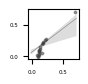

In [10]:
fig, ax = plt.subplots(figsize=(.65, .65))
dis_425=[]
rep_425=[]
colormaps = ['Greys', 'Blues']
for i in range(19):
    
    colormap = plt.get_cmap(colormaps[0])
    a = replicability_results[0][i][1][16]
    b = replicability_results[0][i][2][16]
    plt.scatter(a,b, s=3, alpha=0.5, color=colormap(0.8))
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)

    dis_425.append(replicability_results[0][i][1][16])
    rep_425.append(replicability_results[0][i][2][16])
dis_425 = np.array(dis_425)
rep_425 = np.array(rep_425)

sns.regplot(y=dis_425, x=rep_425, 
                    color=colormap(0.9), 
                    scatter=False,
                    line_kws={"linewidth": 0.5, 'alpha': 0.4}
                    )

In [11]:
dis_425=[]
rep_425=[]
colormaps = ['Greys', 'Blues']
for i in [0,1,3,5,7,8,12,18]:
    
    
    dis_425.append(replicability_results[0][i][1][16])
    rep_425.append(replicability_results[0][i][2][16])
dis_425 = np.array(dis_425)
rep_425 = np.array(rep_425)

dis_425.min(), dis_425.max(), rep_425.min(), rep_425.max()
(dis_425 - rep_425).min(), (dis_425 - rep_425).max()

(np.float64(-0.050412371134020695), np.float64(0.03399999999999999))

[]

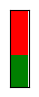

In [12]:
percentage=42;remainder=100-percentage
colors=['green','red']
fig,ax=plt.subplots(figsize=(0.5/2,2/2))
ax.bar(0,percentage,color=colors[0])
ax.bar(0,remainder,bottom=percentage,color=colors[1])
ax.set_ylim(0,100)
ax.set_xticks([])
ax.set_yticks([])

In [13]:
replicability_results = np.array(replicability_results)

[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.8, '0.8')]

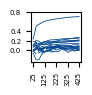

In [14]:
def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')

colormaps = ['Blues']
c = 1
line_width = 0.6
fig, ax = plt.subplots(figsize=(.65,.65))
colormap = plt.get_cmap('Blues')

for i in range(19):
    plt.plot(smooth_array(replicability_results[0][i][2], 2), 
        linewidth=line_width, 
        color=colormap(0.9))

ax.set_xticks([0, 4, 8, 12, 16])
ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
ax.set_yticks([0.0, 0.2, 0.4, 0.8])  # 4 ticks
ax.set_yticklabels([0.0, 0.2, 0.4, 0.8], fontsize=5)

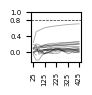

In [15]:
def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')

colormaps = ['Greys']
c = 1
line_width = 0.6
fig, ax = plt.subplots(figsize=(.65,.65))
colormap = plt.get_cmap('Greys')

for i in range(19):
    plt.plot(smooth_array(replicability_results[0][i][2], 2), 
        linewidth=line_width, 
        color=colormap(0.9),
        alpha=0.4)

ax.set_xticks([0, 4, 8, 12, 16])
ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
ax.set_yticks([0.0, 0.4, 0.8, 1.0])  # 4 ticks
ax.set_yticklabels([0.0, 0.4, 0.8, 1.0], fontsize=5)
ax.axhline(y=0.8, color=colormap(.9), linestyle='--', linewidth=0.5)

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'sex'),
 Text(2.5, 0, 'handedness'),
 Text(3.5, 0, 'BMI'),
 Text(4.5, 0, 'education_level'),
 Text(5.5, 0, 'IST_fluid'),
 Text(6.5, 0, 'IST_memory'),
 Text(7.5, 0, 'IST_crystallised'),
 Text(8.5, 0, 'IST_intelligence_total'),
 Text(9.5, 0, 'BAS_drive'),
 Text(10.5, 0, 'BAS_fun'),
 Text(11.5, 0, 'BAS_reward'),
 Text(12.5, 0, 'BIS'),
 Text(13.5, 0, 'NEO_N'),
 Text(14.5, 0, 'NEO_E'),
 Text(15.5, 0, 'NEO_O'),
 Text(16.5, 0, 'NEO_A'),
 Text(17.5, 0, 'NEO_C'),
 Text(18.5, 0, 'STAI_T')]

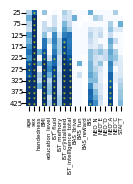

In [16]:
res = []
for i in range(19):
    res.append(replicability_results[0][i][0])
res = np.array(res).T

import seaborn as sns

fig, ax = plt.subplots(figsize=(5/4, 1.25))
sns.heatmap(res, cmap='Blues', cbar=False)
for j in range(19):
        for k in range(17):
            if replicability_results[0][j][0][k] >= 0.8:
                ax.text(j+0.5,k+0.75, '*', color='yellow', ha='center', va='center', fontsize=4)


ax.set_yticks(np.arange(0.5, 17.5, 2)) # ticks should be in the center of the box
ax.set_yticklabels(np.arange(25, 450, 50), rotation=0, fontsize=5, ha='center')  
ax.set_xticks(np.arange(0.5, 19.5, 1)) # ticks should be in the center of the box
ax.set_xticklabels(phenotype_names, rotation=90, fontsize=4)

In [17]:
finalResults = []
for conntype in range(1):
    model_history = np.zeros((19, 3))
    for phenIdx in range(19):
        temp_phen_replicability = np.array(replicability_results[0][phenIdx][0]) #replicability_results[conntype][phenIdx][0]
        start_index = next((i for i, value in enumerate(temp_phen_replicability) if value > 0.8), None)  # correct the code
        #if np.mean(temp_phen_replicability[start_index:]) > 0.8:
        if start_index is not None and np.mean(temp_phen_replicability[start_index:]) > 0.8:
            out_sample_size = np.arange(25, 450, 25)[start_index]
            out_dis_effect_size = replicability_results[conntype][phenIdx][1][start_index]
            out_rep_effect_size = replicability_results[conntype][phenIdx][2][start_index]
        else:
            out_sample_size = np.inf
            out_dis_effect_size = np.inf
            out_rep_effect_size = np.inf
        model_history[phenIdx, 0] = out_sample_size
        model_history[phenIdx, 1] = out_dis_effect_size
        model_history[phenIdx, 2] = out_rep_effect_size
    finalResults.append(model_history)

In [18]:
finalResults = np.array(finalResults)
res_df = pd.DataFrame(finalResults[0])
res_df.index = phenotype_names
res_df.columns = ['Sample Size', 'Discovery Effect Size', 'Replication Effect Size']
new_list = ['demography', 'demography', 'demography', 'demography', 'demography', 'trait', 'trait','trait','trait','trait',
            'trait','trait','trait','trait','trait','trait','trait','trait','trait']    
res_df['category']=new_list
res_df

,Sample Size,Discovery Effect Size,Replication Effect Size,category
age,250.0,0.184318,0.167273,demography
sex,25.0,0.513830,0.474043,demography
handedness,inf,inf,inf,demography
BMI,200.0,0.211522,0.188913,demography
education_level,inf,inf,inf,demography
IST_fluid,225.0,0.186471,0.164118,trait
IST_memory,inf,inf,inf,trait
IST_crystallised,150.0,0.210870,0.212391,trait
IST_intelligence_total,225.0,0.189500,0.187167,trait
BAS_drive,inf,inf,inf,trait


In [19]:
agg_funcs = ['mean', 'median', 'min', 'max']

stats_part1 = res_df[~np.isinf(res_df['Sample Size'])].iloc[:,0:3].agg(agg_funcs).round(2)

combined_stats_df = stats_part1
combined_stats_df

,Sample Size,Discovery Effect Size,Replication Effect Size
mean,228.12,0.22,0.21
median,225.00,0.19,0.18
min,25.00,0.12,0.12
max,425.00,0.51,0.47


In [15]:
finalInd = [0,1,3,5,7,8,12,18]
ef_size_df = []
for mod in range(1):
    e_mod = []
    for i in finalInd:
        e = replicability_results[mod][i][1]
        e_mod.append(e)
    e_mod = np.array(e_mod)
    dis = pd.DataFrame(e_mod).mean(axis=0)

    e_mod = []
    for i in finalInd:
        e = replicability_results[mod][i][2]/replicability_results[mod][i][1] 
        e_mod.append(e)
    e_mod = np.array(e_mod)
    rep = pd.DataFrame(e_mod).mean(axis=0)
    
    dis_rep = pd.concat([dis, rep], axis=1)
    dis_rep.columns = ['discovery', 'replication']
    ef_size_df.append(dis_rep)
ef_size_df = pd.concat(ef_size_df, axis=1)
ef_size_df.columns = ['discovery_streamlines', 'replication_streamlines'
                       ]

ef_size_df = ef_size_df.round(2)
ef_size_df.index = np.arange(25, 450, 25)
ef_size_df 

,discovery_streamlines,replication_streamlines
25,0.46,0.46
50,0.34,0.38
75,0.30,0.46
100,0.28,0.55
125,0.27,0.67
150,0.26,0.69
175,0.24,0.76
200,0.24,0.82
225,0.23,0.88
250,0.24,0.89


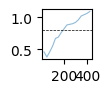

In [19]:
fig, ax = plt.subplots(figsize=(.65, .65))
plt.plot(ef_size_df.iloc[:,1], alpha=0.5, linewidth=0.8)

ax.axhline(y=0.8, color='black', linestyle='--', linewidth=0.5)

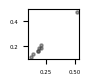

In [ ]:

fig, ax = plt.subplots(figsize=(.65, .65))
colormaps = ['Greys', 'Blues']
for i in range(19):
    colormap = plt.get_cmap(colormaps[0])
    plt.scatter(res_df['Discovery Effect Size'].iloc[i], res_df['Replication Effect Size'].iloc[i], s=5, alpha=0.5, color=colormap(0.8))
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)


In [21]:
finite_sample_sizes = res_df[~np.isinf(res_df['Sample Size'])]
print(finite_sample_sizes.iloc[:,0:3].mean())
print('--------------------------------------')
print(finite_sample_sizes.iloc[:,0:3].median())
finite_sample_sizes['Sample Size'].median()

Sample Size                228.125000
Discovery Effect Size        0.220523
Replication Effect Size      0.205940
dtype: float64
--------------------------------------
Sample Size                225.000000
Discovery Effect Size        0.187985
Replication Effect Size      0.177220
dtype: float64


np.float64(225.0)

In [22]:
finite_sample_sizes = res_df[~np.isinf(res_df['Sample Size']) & (res_df['category'] == 'trait')]
print(finite_sample_sizes.iloc[:,0:3].mean())
print('--------------------------------------')
print(finite_sample_sizes.iloc[:,0:3].median())
finite_sample_sizes['Sample Size'].median()
finite_sample_sizes

Sample Size                270.000000
Discovery Effect Size        0.170902
Replication Effect Size      0.163459
dtype: float64
--------------------------------------
Sample Size                225.000000
Discovery Effect Size        0.186471
Replication Effect Size      0.164118
dtype: float64


,Sample Size,Discovery Effect Size,Replication Effect Size,category
IST_fluid,225.0,0.186471,0.164118,trait
IST_crystallised,150.0,0.210870,0.212391,trait
IST_intelligence_total,225.0,0.189500,0.187167,trait
BIS,425.0,0.122889,0.116444,trait
NEO_A,325.0,0.144783,0.137174,trait
